In [5]:
import pandas as pd
all_shots = pd.read_csv("shots/shots.csv")
all_shots

all_shots["SHOT_VALUE"] = all_shots["SHOT_TYPE"].apply(lambda x: 3 if "3PT" in x else 2)

Rows removed due to missing values: 0
Train shape: (154153, 545) Test shape: (51385, 545)

Training Random Forest...
Random Forest Metrics:
Accuracy: 0.6344069280918556
F1 Score: 0.5530335474660957
ROC-AUC: 0.6745127500587245


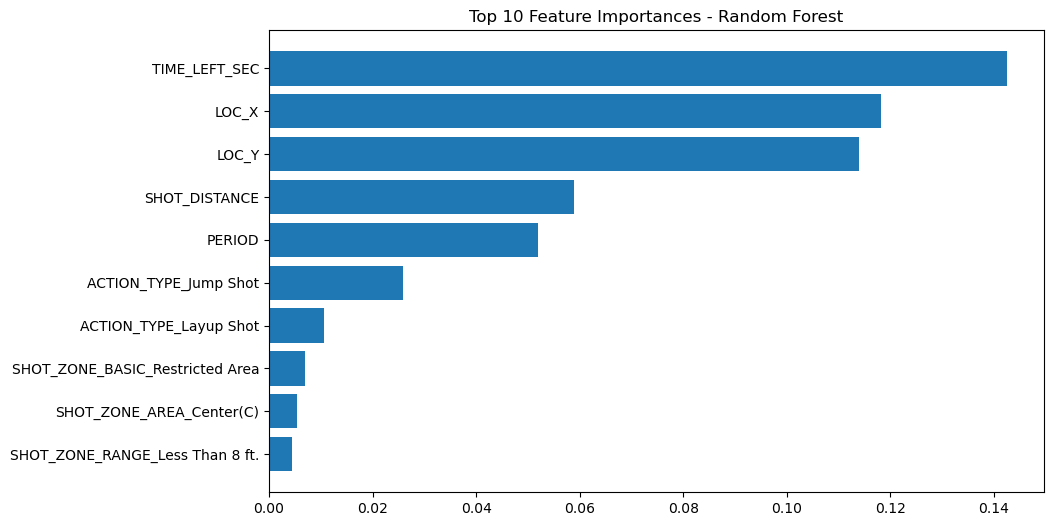


Training XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [21:20:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Metrics:
Accuracy: 0.6551717427264766
F1 Score: 0.5509743797673653
ROC-AUC: 0.7000354147279304


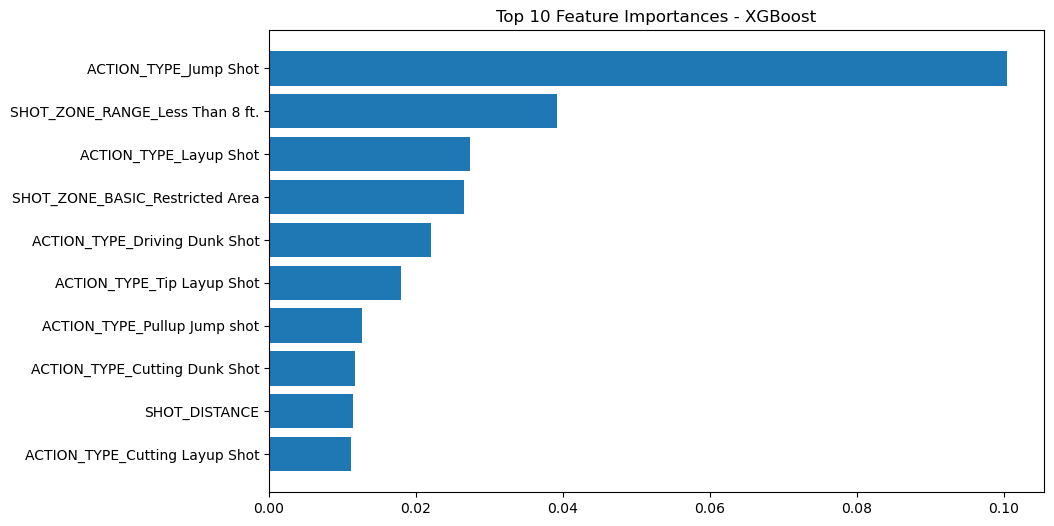


Training Gradient Boosting...
Gradient Boosting Metrics:
Accuracy: 0.6532840323051474
F1 Score: 0.547840211156794
ROC-AUC: 0.6983339128198258


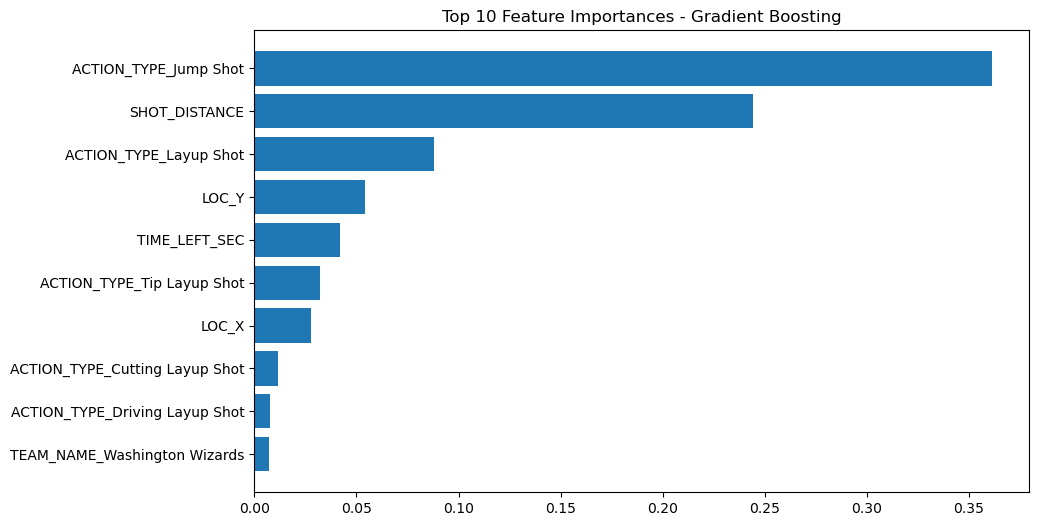


Training Logistic Regression...
Logistic Regression Metrics:
Accuracy: 0.6487690960397003
F1 Score: 0.5453217110898373
ROC-AUC: 0.6902940532658651

Training MLP Classifier...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Classifier Metrics:
Accuracy: 0.5900360027245305
F1 Score: 0.5341235791056659
ROC-AUC: 0.6155749290342671

Model Comparison:
                 Model  Accuracy        F1   ROC-AUC
0        Random Forest  0.634407  0.553034  0.674513
1              XGBoost  0.655172  0.550974  0.700035
2    Gradient Boosting  0.653284  0.547840  0.698334
3  Logistic Regression  0.648769  0.545322  0.690294
4       MLP Classifier  0.590036  0.534124  0.615575


In [6]:
# ===== 1️⃣ Imports =====
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

# ===== 2️⃣ Prepare Dataset =====
# Drop rows with missing values
rows_before = all_shots.shape[0]
all_shots_clean = all_shots.dropna()
rows_after = all_shots_clean.shape[0]
print(f"Rows removed due to missing values: {rows_before - rows_after}")



# Combine minutes and seconds into TIME_LEFT_SEC
all_shots_clean["TIME_LEFT_SEC"] = all_shots_clean["MINUTES_REMAINING"]*60 + all_shots_clean["SECONDS_REMAINING"]

# Drop unnecessary columns
drop_cols = ["GAME_ID","GAME_EVENT_ID","PLAYER_ID","TEAM_ID","EVENT_TYPE","SHOT_ATTEMPTED_FLAG","GAME_DATE","HTM","VTM","MINUTES_REMAINING","SECONDS_REMAINING"]
all_shots_clean = all_shots_clean.drop(columns=drop_cols)

# Define features and target
features = [
    "PLAYER_NAME","TEAM_NAME","ACTION_TYPE","SHOT_TYPE",
    "SHOT_ZONE_BASIC","SHOT_ZONE_AREA","SHOT_ZONE_RANGE",
    "SHOT_DISTANCE","LOC_X","LOC_Y","PERIOD","TIME_LEFT_SEC","SHOT_VALUE"
]
target = "SHOT_MADE_FLAG"

df_model = all_shots_clean[features + [target]].copy()

# One-hot encode categorical variables
categorical_features = ["PLAYER_NAME","TEAM_NAME","ACTION_TYPE","SHOT_TYPE","SHOT_ZONE_BASIC","SHOT_ZONE_AREA","SHOT_ZONE_RANGE"]
df_model = pd.get_dummies(df_model, columns=categorical_features, drop_first=True)

# Features and target
X = df_model.drop(columns=[target])
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Optional: scale numeric features for MLP/Logistic Regression
scaler = StandardScaler()
num_features = ["SHOT_DISTANCE","LOC_X","LOC_Y","PERIOD","TIME_LEFT_SEC","SHOT_VALUE"]
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# ===== 3️⃣ Define Classifiers =====
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=250, max_depth=6, learning_rate=0.1,
                             subsample=0.9, colsample_bytree=0.8,
                             eval_metric="logloss", use_label_encoder=False,
                             n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,50), max_iter=300, random_state=42)
}

# ===== 4️⃣ Train & Evaluate =====
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    print(f"{name} Metrics:")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    if roc is not None:
        print("ROC-AUC:", roc)
    
    # Save results
    results.append({"Model": name, "Accuracy": acc, "F1": f1, "ROC-AUC": roc})
    
    # Feature importance for tree-based models
    if name in ["Random Forest","XGBoost","Gradient Boosting"]:
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # top 10 features
        plt.figure(figsize=(10,6))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
        plt.title(f"Top 10 Feature Importances - {name}")
        plt.show()

# ===== 5️⃣ Summary Table =====
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# ===== 6️⃣ Compute Expected Points (example for XGBoost) =====
all_shots_clean["P_MADE_XGB"] = models["XGBoost"].predict_proba(X)[:,1]
all_shots_clean["EXPECTED_POINTS_XGB"] = all_shots_clean["P_MADE_XGB"] * all_shots_clean["SHOT_VALUE"]

